In [304]:
import numpy
import pandas
import os
import morphio

import bluepysnap as snap
from scipy import stats
from conntility.subcellular import MorphologyPathDistanceCalculator

fn_in = "/Users/mwr/Documents/artefacts/SONATA/O1_data/circuit_config.json"
circ = snap.Circuit(fn_in)

In [272]:
def morphology_and_pathdistance_calculator(circ, node_population, node_id):
    node = circ.nodes[node_population]
    morph_name = node.morph.get_name(node_id)
    try:
        morph = morphio.Morphology(os.path.join(node.config["alternate_morphologies"]["h5v1"], morph_name) + ".h5")
    except:
        raise RuntimeError("Error loading hdf5 morphology for {0} - {1}".format(node_population, node_id))
    PD = MorphologyPathDistanceCalculator(morph)
    return morph, PD


def all_syns_on(circ, node_population, node_id, node_props):
    node = circ.nodes[node_population]
    syns = []
    syn_edge_names = []
    syn_pre_pop_names = []
    pre_node_props = []

    syn_props = ["afferent_section_id", "afferent_segment_id",
                 "afferent_segment_offset",
                 "@source_node", "@target_node"]
    reserved_props = syn_props + ["source_population", "edge_population", "edge_id"]
    int_props = ["afferent_section_id", "afferent_segment_id", "@source_node", "@target_node", "edge_id"]
    _node_props = [_prop for _prop in node_props if _prop not in reserved_props]
    
    for edge_name in node.target_in_edges():
        edge = circ.edges[edge_name]
        if not numpy.all([_x in edge.property_names for _x in syn_props]):
            print("Skipping!")
            continue
        new_syns = edge.afferent_edges(node_id, properties=syn_props)
        if len(new_syns) == 0:
            continue
        syns.append(new_syns)
        pre_node = circ.nodes[edge.source.name]
        __node_props = [_x for _x in _node_props if _x in pre_node.property_names]
        loaded_node_props = pre_node.get(syns[-1]["@source_node"], properties=__node_props)
        loaded_node_props = loaded_node_props.reindex(columns=_node_props, index=syns[-1]["@source_node"].values)
        pre_node_props.append(loaded_node_props)
        syn_edge_names.append(edge_name)
        syn_pre_pop_names.append(edge.source.name)

    syns = pandas.concat(syns, axis=0, names=["source_population", "edge_population"],
                         keys=list(zip(syn_pre_pop_names, syn_edge_names)))
    syns = syns.reset_index([2]).rename(columns={"level_2": "edge_id"})
    pre_node_props = pandas.concat(pre_node_props, axis=0, names=["source_population", "edge_population"],
                                   keys=list(zip(syn_pre_pop_names, syn_edge_names)))
    pre_node_props = pre_node_props.reset_index([2]).drop(columns=["node_ids"])

    syns = pandas.concat([syns, pre_node_props], axis=1).reset_index()

    for prop in int_props:
        syns[prop] = syns[prop].astype(int)

    return syns

# Section types are also in the synapse table, but I do not trust its presence in all circuits
def add_section_types(syns, morph):
    sec_types = numpy.array([1] + [int(_sec.type) for _sec in morph.sections])
    syns["afferent_section_type"] = sec_types[syns["afferent_section_id"]]


def apply_filters(syns, filter_dict, drop_nan=True):
    for k, v in filter_dict.items():
        assert k in syns.columns, "No property {0} could be loaded".format(k)  # This cannot happen!
        if isinstance(v, list):
            v = syns[k].isin(v)
        else:
            v = syns[k] == v
        if not drop_nan:
            v = v | syns[k].isna()
        syns = syns.loc[v]
    return syns

def relevant_path_distances(PD, syns):
    pw_pds = PD.path_distances(syns)

    soma = pandas.DataFrame({"afferent_section_id": [0], "afferent_segment_id": [0], "afferent_segment_offset": [0.0]})
    soma_pds = PD.path_distances(soma, locs_to=syns)[0]
    return soma_pds, pw_pds

In [313]:
node_population = "S1nonbarrel_neurons"
node_id = 110
prop_filters = {"synapse_class": ["EXC", "INH"], "afferent_section_type": [1]}
node_props = list(prop_filters.keys())

morph, PD = morphology_and_pathdistance_calculator(circ, node_population, node_id)
syns = all_syns_on(circ, node_population, node_id, node_props)
add_section_types(syns, morph)
syns = apply_filters(syns, prop_filters, drop_nan=False)
soma_pds, pw_pds = relevant_path_distances(PD, syns)

/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_67307/3949618188.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pre_node_props = pandas.concat(pre_node_props, axis=0, names=["source_population", "edge_population"],


In [314]:
syns

,source_population,edge_population,edge_id,afferent_section_id,afferent_segment_id,afferent_segment_offset,@source_node,@target_node,synapse_class,afferent_section_type
47,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26593,0,0,0.0,21542,110,EXC,1
53,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26599,0,0,0.0,26034,110,INH,1
286,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26832,0,0,0.0,151620,110,INH,1
287,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26833,0,0,0.0,151620,110,INH,1
389,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26935,0,0,0.0,211122,110,INH,1
419,S1nonbarrel_neurons,external_S1nonbarrel_neurons__S1nonbarrel_neur...,7260,0,0,0.0,108812,110,INH,1


In [310]:
def select_randomly(syns, n=None, p=None, raise_insufficient=False):
    assert p is not None or n is not None, "Must specify number or fraction of synapses!"
    if n is not None:
        if n > len(syns):
            if raise_insufficient:
                raise RuntimeError("Fewer than the requested count of {0} found!".format(n))
        return syns.iloc[numpy.random.choice(len(syns), numpy.minimum(n, len(syns)), replace=False)]
    if p is not None:
        if p < 0.0 or p > 1.0:
            raise ValueError("p must be between 0 and 1!")
        picked = numpy.random.rand(len(syns)) < p
        return syns.loc[picked]

def select_minmax_distance(syns, soma_pds, soma_pd_min, soma_pd_max, n=None, p=None, raise_insufficient=False):
    valid = (soma_pds >= soma_pd_min) & (soma_pds < soma_pd_max)
    return select_randomly(syns.loc[valid], n=n, p=p, raise_insufficient=raise_insufficient)

def select_closest_to_path_distance(syns, soma_pds, target_soma_pd, n, raise_insufficient=False):
    if n > len(syns):
        if raise_insufficient:
            raise RuntimeError("Fewer than the requested count of {0} found!".format(n))
    srt_idx = numpy.argsort(numpy.abs(soma_pds - target_soma_pd))
    return syns.iloc[srt_idx[:n]]

def _pd_gaussian_selector(soma_pds, soma_pd_mean, soma_pd_sd, n, raise_insufficient=False):
    if (n > len(soma_pds)) and raise_insufficient:
        raise RuntimeError("Fewer than the requested count of {0} found!".format(n))
    
    distr = stats.norm(soma_pd_mean, soma_pd_sd).pdf(soma_pds)
    sel_idx = numpy.random.choice(range(len(soma_pds)), numpy.minimum(n, len(syns)),
                                  p=distr/distr.sum())
    return sel_idx

def select_by_path_distance(syns, soma_pds, soma_pd_mean, soma_pd_sd, n, raise_insufficient=False):
    return syns.iloc[_pd_gaussian_selector(soma_pds, soma_pd_mean, soma_pd_sd,
                                           n, raise_insufficient=raise_insufficient)]

def select_clusters_by_max_distance(syns, soma_pds, pw_pds, n_clusters, cluster_max_distance, 
                                    soma_pd_mean=None, soma_pd_sd=None,
                                    raise_insufficient=False):
    syns_out = []
    for _ in range(n_clusters):
        if len(syns) == 0:
            if raise_insufficient:
                raise RuntimeError("Fewer than the requested count of {0} clusters possible!".format(n_clusters))
            break
        if soma_pd_mean is not None and soma_pd_sd is not None:
            ctr = _pd_gaussian_selector(soma_pds, soma_pd_mean, soma_pd_sd, 1,
                                        raise_insufficient=True)[0]
        else:
            ctr = numpy.random.choice(len(syns))
        clstr_ids = pw_pds[ctr] < cluster_max_distance
        syns_out.append(syns.loc[clstr_ids])
        syns = syns.loc[~clstr_ids]
        pw_pds = pw_pds[numpy.ix_(~clstr_ids, ~clstr_ids)]
        if soma_pds is not None:
            soma_pds = soma_pds[~clstr_ids]
    return pandas.concat(syns_out, axis=0, names=["cluster_id"], keys=range(len(syns_out))).reset_index(0)

def select_clusters_by_count(syns, soma_pds, pw_pds, n_clusters, n_per_cluster,
                             soma_pd_mean=None, soma_pd_sd=None,
                             raise_insufficient=False):
    syns_out = []
    for _ in range(n_clusters):
        if len(syns) < n_per_cluster:
            if raise_insufficient:
                raise RuntimeError("Fewer than the requested count of {0} clusters possible!".format(n_clusters))
            break
        if soma_pd_mean is not None and soma_pd_sd is not None:
            ctr = _pd_gaussian_selector(soma_pds, soma_pd_mean, soma_pd_sd, 1,
                                        raise_insufficient=True)[0]
        else:
            ctr = numpy.random.choice(len(syns))
        clstr_ids = numpy.argsort(pw_pds[ctr])[:n_per_cluster]
        other_ids = numpy.setdiff1d(range(len(syns)), clstr_ids)
        syns_out.append(syns.iloc[clstr_ids])
        syns = syns.iloc[other_ids]
        pw_pds = pw_pds[numpy.ix_(other_ids, other_ids)]
        if soma_pds is not None:
            soma_pds = soma_pds[other_ids]
    return pandas.concat(syns_out, axis=0, names=["cluster_id"], keys=range(len(syns_out))).reset_index(0)


In [312]:
select_clusters_by_count(syns, soma_pds, pw_pds, 3, 10, 
                         soma_pd_mean=100, soma_pd_sd=10.0, raise_insufficient=False)

,cluster_id,source_population,edge_population,edge_id,afferent_section_id,afferent_segment_id,afferent_segment_offset,@source_node,@target_node,synapse_class,afferent_section_type
35,0,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26581,604,33,1.922149,11176,110,EXC,3
463,0,POm,POm__S1nonbarrel_neurons__chemical,12160,604,33,1.319118,3894,110,NaN,3
11,0,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26557,604,30,0.461901,580,110,EXC,3
548,0,POm,POm__S1nonbarrel_neurons__chemical,12245,604,30,0.360810,7612,110,NaN,3
462,0,POm,POm__S1nonbarrel_neurons__chemical,12159,604,29,0.151096,3894,110,NaN,3
90,0,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26636,604,27,0.471741,33951,110,INH,3
206,0,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26752,604,26,1.928668,110139,110,EXC,3
348,0,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26894,604,40,1.599070,163317,110,EXC,3
197,0,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26743,604,24,0.899540,65577,110,EXC,3
384,0,S1nonbarrel_neurons,S1nonbarrel_neurons__S1nonbarrel_neurons__chem...,26930,604,42,0.257204,203873,110,EXC,3


In [300]:
numpy.argsort(pw_pds[195])

array([195, 256, 369, 377, 296, 313, 397, 556, 194, 491, 416, 415, 484,
       361, 458, 304, 183, 322, 360,  34, 314, 247, 297, 331, 129, 148,
       529, 437, 252, 173, 174, 175, 426, 263, 176, 446, 177, 351, 396,
       535, 289, 531, 178, 114, 267, 113, 117, 395,  83, 287,  53, 286,
       419, 389,  47, 517, 200, 390, 391, 186,  54, 284, 392, 127, 364,
         8, 288, 184, 107, 185, 362,  73, 561, 454, 563, 474, 337, 226,
       272, 126,  32,  20,  82, 274, 273, 147, 181,  52, 180,  48, 502,
       285, 494, 282, 467, 559, 327, 498, 407, 146, 170,  18, 329, 406,
       277,  21, 182, 224, 479, 524, 112, 118,  87, 111, 326, 208, 403,
       235, 488, 438,  85, 228,   7, 356,  49, 461, 506, 167,  96, 469,
       526, 552,   4, 449, 427,  69, 159,   3, 223, 276, 365, 108, 103,
       261, 542, 121, 518, 161, 102, 160, 120, 507,  38, 149, 275, 259,
       435, 453,   2, 378,  70, 141, 144,  88, 104, 270, 473,   5, 532,
       444, 209, 110, 545, 268, 447, 346, 203, 522, 134,  31, 29

In [76]:
on_soma = numpy.nonzero(soma_pds == 0)[0]

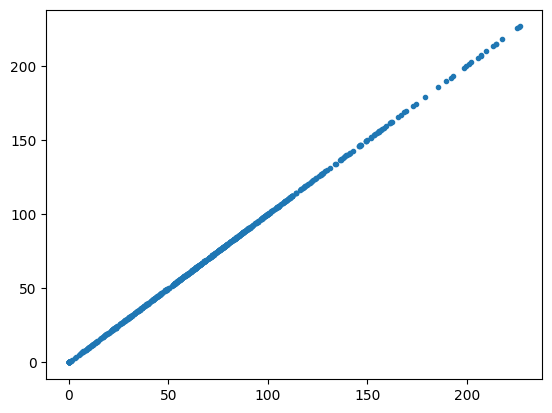

In [80]:
from matplotlib import pyplot as plt

plt.plot(pw_pds[46], soma_pds, '.')

In [ ]:
edge = circ.edges['POm__S1nonbarrel_neurons__chemical']
syns = edge.afferent_edges(123, properties=["afferent_section_id", "afferent_segment_id", "afferent_segment_offset", "@source_node", "@target_node"])

,afferent_section_id,afferent_segment_id,afferent_segment_offset,@source_node,@target_node
14365,1028,64,1.438458,1842,123
14366,1021,11,6.899171,1842,123
14367,1028,20,0.509678,1842,123
14368,1001,6,1.494967,1842,123
14369,1026,8,1.736995,1842,123
...,...,...,...,...,...
14622,961,1,0.759230,8537,123
14623,961,4,0.502234,8537,123
14624,967,12,1.161405,8537,123
14625,1002,12,1.346489,8570,123


In [1]:
import numpy
import pandas
import morphio

from scipy import stats
from conntility.subcellular import MorphologyPathDistanceCalculator

fn_in = "/Users/mwr/Documents/repositories/obi-one/examples/example_data/morphologies/L5_TPC:A_MusMusculus_PrimarySomatosensory_C060114A5/C060114A5.asc"

m = morphio.Morphology(fn_in)

In [108]:
def path_distance_all_segments_from(locs_ref, m, PD, normalized_seg_loc=0.5, lst_sec_types=None):
    kwargs = {
        "str_section_id": 'section_id',
        "str_segment_id": 'segment_id',
        "str_offset": 'segment_offset'
    }
    locs_all = pandas.concat([
        pandas.DataFrame({
            "segment_id": numpy.arange(m.sections[i].n_points - 1),
            "section_id": numpy.ones(m.sections[i].n_points - 1, dtype=int) * (i + 1),
            "section_type": numpy.ones(m.sections[i].n_points - 1, dtype=int) * int(m.sections[i].type),
            "segment_length": numpy.linalg.norm(numpy.diff(m.sections[i].points, axis=0), axis=1)
        })
        for i in range(len(m.sections))], axis=0).reset_index(drop=True)
    if lst_sec_types is not None:
        locs_all = locs_all.loc[locs_all["section_type"].isin(lst_sec_types)].reset_index(drop=True)
    locs_all["segment_offset"] = normalized_seg_loc * locs_all["segment_length"]

    pd = PD.path_distances(locs_ref, locs_all, **kwargs)
    pd = [pandas.Series(_pd, name="path_distance") for _pd in pd]
    # if len(locs_ref) == 1:
    #     return pandas.concat([locs_all, pd[0]], axis=1)

    return pandas.concat([
        pandas.concat([locs_all, _pd], axis=1) for _pd in pd
        ], axis=0, keys=range(len(pd)), names=["reference_loc_index"])

def select_segments_as_cluster_centers(n_pick, locs, distr, lst_sec_types=None):
    p = distr.pdf(locs["path_distance"])
    if lst_sec_types is not None:
        p = p * locs["section_type"].isin(lst_sec_types).astype(float)
    # locs["p_pick"] = p

    selected_ids = numpy.random.choice(locs.index, n_pick,
                                       p=p/p.sum())
    return locs.iloc[selected_ids]

def find_normalized_interval_below_zero(a, b):
    min_norm_pd = float(0)
    max_norm_pd = float(1)
    if (b - a) > 0: # becomes invalid near the end
        max_norm_pd = numpy.minimum(-a / (b - a), max_norm_pd)
    elif (b - a) == 0:
        max_norm_pd = 0.0
    else:
        min_norm_pd = numpy.maximum(-a / (b - a), min_norm_pd)
    return min_norm_pd, max_norm_pd

def min_max_offset_in_segment(row, max_distance):
    a = row["path_distance_start"] - max_distance
    b = row["path_distance_end"] - max_distance
    l = row["segment_length"]
    min_norm_pd, max_norm_pd = find_normalized_interval_below_zero(a, b)

    return pandas.Series({
        "min_seg_offset": min_norm_pd * l,
        "max_seg_offset": max_norm_pd * l
    })

def min_max_offset_for_center_segment(row, max_distance):
    a = row["path_distance_start"] - max_distance
    b = row["path_distance_end"] - max_distance
    l = row["segment_length"]
    c = -max_distance
    min_norm_pd, _ = find_normalized_interval_below_zero(a, c)
    _, max_norm_pd = find_normalized_interval_below_zero(c, b)

    return pandas.Series({
        "min_seg_offset": 0.5 * min_norm_pd * l,
        "max_seg_offset": (0.5 + 0.5 * max_norm_pd) * l
    })

def candidate_segments_all_morphology(locs): 
    return pandas.DataFrame({
        "min_seg_offset": numpy.zeros(len(locs), dtype=float),
        "max_seg_offset": locs["segment_length"].values
    }, index=locs.index)

def __candidate_segments_for_center(id_center, locs, max_dist, m, PD):
    loc_center = locs.loc[id_center:id_center]
    res_seg_start = path_distance_all_segments_from(loc_center, m, PD, 0.0).rename(columns={"path_distance": "path_distance_start"})
    res_seg_end = path_distance_all_segments_from(loc_center, m, PD, 1.0).rename(columns={"path_distance": "path_distance_end"})
    res = pandas.concat([res_seg_start, res_seg_end[["path_distance_end"]]], axis=1)
    
    _valid = (res["path_distance_start"] < max_dist) | (res["path_distance_end"] < max_dist)
    _valid[id_center] = True
    cands = res.loc[_valid]
    
    intervals = cands.apply(min_max_offset_in_segment, args=(max_dist,), axis=1)
    intervals.loc[id_center] = min_max_offset_for_center_segment(res.loc[id_center], max_dist)
    return intervals

def candidate_segments_for_center(ids_center, locs, max_dist, m, PD, lst_sec_types=None):
    loc_center = locs.loc[ids_center]
    res_seg_start = path_distance_all_segments_from(loc_center, m, PD, 0.0, lst_sec_types=lst_sec_types).rename(columns={"path_distance": "path_distance_start"})
    res_seg_end = path_distance_all_segments_from(loc_center, m, PD, 1.0, lst_sec_types=lst_sec_types).rename(columns={"path_distance": "path_distance_end"})

    res = pandas.concat([res_seg_start, res_seg_end[["path_distance_end"]]], axis=1)

    _valid = (res["path_distance_start"] < max_dist) | (res["path_distance_end"] < max_dist)
    _valid[list(enumerate(ids_center))] = True
    cands = res.loc[_valid]

    intervals = cands.apply(min_max_offset_in_segment, args=(max_dist,), axis=1)
    for tpl in enumerate(ids_center):
        intervals.loc[tpl] = min_max_offset_for_center_segment(res.loc[tpl], max_dist)
    return intervals

def __select_places_from_candidate_list(n, cands, locs):
    p = cands.diff(axis=1).values[:, 1]
    p[numpy.isnan(p)] = 0

    selected = cands.loc[numpy.random.choice(cands.index, n, p=p/p.sum())]
    selected = selected["min_seg_offset"] + numpy.random.rand(n) * (selected["max_seg_offset"] - selected["min_seg_offset"])

    output = locs.loc[selected.index].sort_index().drop(columns=["segment_offset"])
    output["segment_offset"] = selected.values    
    return output

def select_places_from_candidate_list(n, cands, locs):
    def randomly_pick_with_p(df_in):
        df_in = df_in.droplevel(0)
        selected = df_in.loc[numpy.random.choice(df_in.index, n, p=df_in["p"]/df_in["p"].sum())]
        selected = selected["min_seg_offset"] + numpy.random.rand(n) * (selected["max_seg_offset"] - selected["min_seg_offset"])
        
        output = locs.loc[selected.index].sort_index().drop(columns=["segment_offset"])
        output["segment_offset"] = selected.values   
        return output

    p = cands.diff(axis=1).values[:, 1]
    p[numpy.isnan(p)] = 0
    cands["p"] = p

    return cands.groupby("reference_loc_index").apply(randomly_pick_with_p)

def map_presynaptic_ids(df, n_per_center):
    rnd = numpy.random.randint(0, n_per_center, len(df))
    df["presyn_id"] = df["reference_loc_index"] * n_per_center + rnd

def add_normalized_section_offset(df, m, PD):
    sec_lengths = numpy.array([
        numpy.linalg.norm(numpy.diff(sec.points, axis=0), axis=1).sum()
        for sec in m.sections
    ])
    sec_o = PD.O[df["section_id"] - 1, df["segment_id"]]
    sec_l = sec_lengths[df["section_id"] - 1]
    df["normalized_section_offset"] = sec_o / sec_l

def generate_neurite_locations_on(m, n_centers, n_per_center, srcs_per_center,
                                  center_pd_mean, center_pd_sd, 
                                  max_dist_from_center,
                                  lst_section_types=None):
    PD = MorphologyPathDistanceCalculator(m)

    soma = pandas.DataFrame({
            "section_id": [0],
            "segment_id": [0],
            "segment_offset": [0]
        })
    print("Calculating distances from the soma...")
    locs = path_distance_all_segments_from(soma, m, PD, lst_sec_types=lst_section_types).loc[0]

    if max_dist_from_center is None:
        _cands_all_morph = candidate_segments_all_morphology(locs)
        lst_candidates_per_center = pandas.concat([
            _cands_all_morph for _ in range(n_centers)
            ], axis=0, keys=range(n_centers), names=["reference_loc_index"])
    else:
        distr = stats.norm(center_pd_mean, center_pd_sd)
        print("Selecting {0} centers".format(n_centers))
        centers = select_segments_as_cluster_centers(n_centers, locs, distr, lst_sec_types=None)
        print("Building candidates for {0} centers".format(n_centers))
        lst_candidates_per_center = candidate_segments_for_center(centers.index,
                                                                  locs, max_dist_from_center, 
                                                                  m, PD, lst_sec_types=lst_section_types)
    print("Building groups of {0} for {1} centers".format(n_per_center, n_centers))
    all_clusters = select_places_from_candidate_list(n_per_center, lst_candidates_per_center, locs)

    relevant_cols = ["segment_id", "section_id", "section_type", "segment_offset", "path_distance"]
    all_clusters = all_clusters.droplevel(1)[relevant_cols].reset_index()

    map_presynaptic_ids(all_clusters, srcs_per_center)
    add_normalized_section_offset(all_clusters, m, PD)
    return all_clusters

# Use case 1: Tight clusters close to the soma

We set the path distance from the soma to 50 +- 10.
The individual clusters place synapses within 20 um

In [154]:
all_clusters = generate_neurite_locations_on(m, 25, 10, 1, 50.0, 10.0, 20.0, lst_section_types=[3, 4])

Calculating distances from the soma...
Selecting 25 centers
Building candidates for 25 centers
Building groups of 10 for 25 centers


In [155]:
all_clusters

,reference_loc_index,segment_id,section_id,section_type,segment_offset,path_distance,presyn_id,normalized_section_offset
0,0,3,185,3,0.034053,19.898239,0,0.148289
1,0,4,185,3,1.803997,22.058884,0,0.192435
2,0,8,185,3,1.379166,27.004898,0,0.299568
3,0,9,185,3,0.341702,28.871721,0,0.331726
4,0,9,185,3,0.961424,28.871721,0,0.331726
...,...,...,...,...,...,...,...,...
245,24,11,364,4,2.346725,56.562454,24,0.570777
246,24,13,364,4,0.436743,61.523102,24,0.691955
247,24,14,364,4,0.964224,63.851932,24,0.743595
248,24,16,364,4,0.278329,67.333188,24,0.832186


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_16400/321919632.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))


presyn_id
0     36.178402
1     58.576756
2     40.159338
3     57.871936
4     47.741797
5     67.889608
6     26.878732
7     62.259749
8     52.260271
9     56.230291
10    43.376006
11    43.462178
12    34.442704
13    49.068985
14    55.139577
15    60.592048
16    55.310830
17    55.844068
18    52.396001
19    33.522748
20    49.423537
21    32.611925
22    40.878929
23    55.982276
24    55.472140
Name: path_distance, dtype: float64

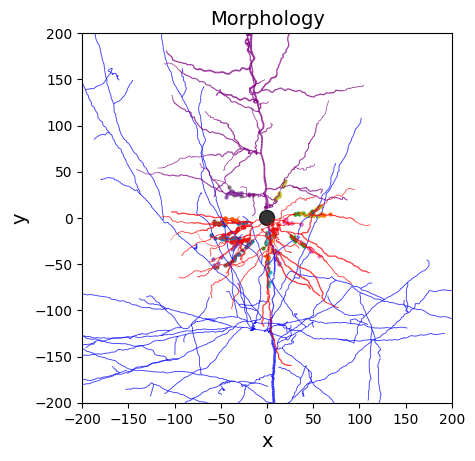

In [156]:
import neurom.view
from matplotlib import pyplot as plt

def location_xyz(row):
    secid = int(row["section_id"])
    segid = int(row["segment_id"])
    o = row["segment_offset"]
    seg = m.sections[secid - 1].points[segid:(segid + 2)]
    dseg = numpy.diff(seg, axis=0)[0]
    dseg = dseg / numpy.linalg.norm(dseg)
    return pandas.Series(seg[0] + o * dseg,
                         index=["x", "y", "z"])


xyz = pandas.concat([all_clusters.apply(location_xyz, axis=1), all_clusters["presyn_id"]], axis=1)
neurom.view.plot_morph(neurom.io.utils.Morphology(m))
xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))
plt.gca().set_xlim([-200, 200])
plt.gca().set_ylim([-200, 200])

display(all_clusters.groupby("presyn_id")["path_distance"].mean())

# Use case 2: Same, but more relaxed clustering

We set the maximum distance from the cluster center to 150 um instead.

Calculating distances from the soma...
Selecting 25 centers
Building candidates for 25 centers
Building groups of 10 for 25 centers


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_16400/309795959.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))


reference_loc_index
0     92.732510
1     31.013339
2     55.586922
3     53.515729
4     53.420975
5     69.731066
6     54.017189
7     69.058136
8     67.901903
9     44.034159
10    43.825605
11    56.695960
12    63.036069
13    65.459976
14    44.712500
15    49.877000
16    66.855991
17    47.879695
18    35.901141
19    73.711084
20    49.746339
21    52.600374
22    54.241104
23    51.014581
24    38.990025
Name: path_distance, dtype: float64

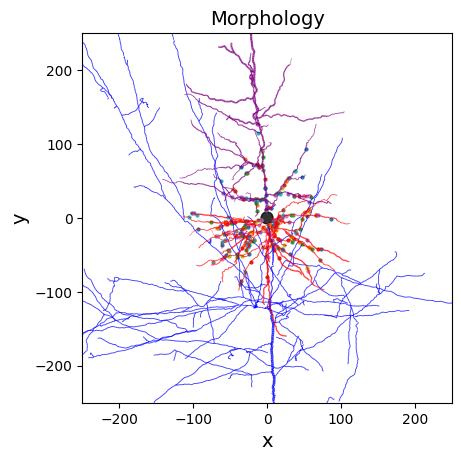

In [157]:
all_clusters = generate_neurite_locations_on(m, 25, 10, 1, 50.0, 10.0, 150.0, lst_section_types=[3, 4])

xyz = pandas.concat([all_clusters.apply(location_xyz, axis=1), all_clusters["presyn_id"]], axis=1)
neurom.view.plot_morph(neurom.io.utils.Morphology(m))
xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))
plt.gca().set_xlim([-250, 250])
plt.gca().set_ylim([-250, 250])

display(all_clusters.groupby("reference_loc_index")["path_distance"].mean())

# Use case 3: Tight clusters, but anywhere on the morphology

We set the path distance from the soma to 0, but with very high sd. This essentially removes that constraint.
The code guarantees that in this case each neurite location is equally likely to be picked as a center.

Individual clusters remain tight.

Calculating distances from the soma...
Selecting 25 centers
Building candidates for 25 centers
Building groups of 10 for 25 centers


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_16400/2772196615.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))


reference_loc_index
0     161.160689
1     695.186596
2       6.341554
3      40.792308
4     673.289705
5     155.589160
6      27.399654
7     168.780983
8     147.060500
9     114.861079
10    147.450141
11    288.155059
12    100.319419
13     88.534307
14    770.295198
15     40.457984
16     87.037546
17     98.400425
18    115.919900
19     45.839844
20     71.057975
21     32.207810
22    637.201012
23     57.342010
24    651.726803
Name: path_distance, dtype: float64

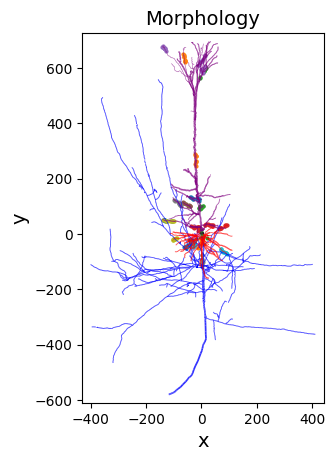

In [166]:
all_clusters = generate_neurite_locations_on(m, 25, 10, 1, 0.0, 1E20, 25.0, lst_section_types=[3, 4])

xyz = pandas.concat([all_clusters.apply(location_xyz, axis=1), all_clusters["presyn_id"]], axis=1)
neurom.view.plot_morph(neurom.io.utils.Morphology(m))
xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))

display(all_clusters.groupby("reference_loc_index")["path_distance"].mean())


# Use case 4. No clustering
This is done by setting the maximum distance from the center to None. The same can in principle be accomplished by setting it to a very large value, but this method is much faster.

As a result, the locations of individual "clusters" are not clustered at all. 

Calculating distances from the soma...
Building groups of 5 for 100 centers


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_16400/3712133901.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _ = xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))


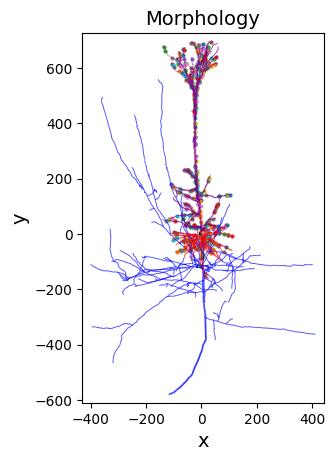

In [159]:
all_clusters = generate_neurite_locations_on(m, 100, 5, 1, 0.0, 1E20, None, lst_section_types=[3, 4])

xyz = pandas.concat([all_clusters.apply(location_xyz, axis=1), all_clusters["presyn_id"]], axis=1)
neurom.view.plot_morph(neurom.io.utils.Morphology(m))
_ = xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))

This shows the alternative, slower version

Calculating distances from the soma...
Selecting 100 centers
Building candidates for 100 centers
Building groups of 5 for 100 centers


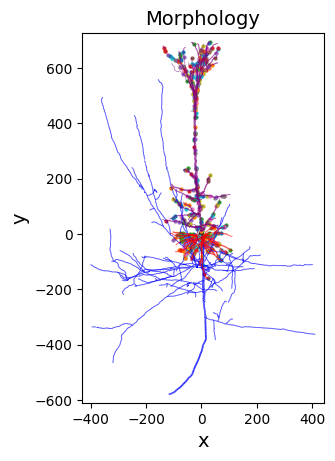

In [8]:
all_clusters = generate_neurite_locations_on(m, 100, 5, 1, 0.0, 1E20, 1000, lst_section_types=[3, 4])

xyz = pandas.concat([all_clusters.apply(location_xyz, axis=1), all_clusters["presyn_id"]], axis=1)
neurom.view.plot_morph(neurom.io.utils.Morphology(m))
_ = xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=4))

# Use case 5: Single cluster, but multiple presynaptics innervating

Calculating distances from the soma...
Selecting 1 centers
Building candidates for 1 centers
Building groups of 100 for 1 centers


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_16400/3289358159.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _ = xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=12))


(200.0, 400.0)

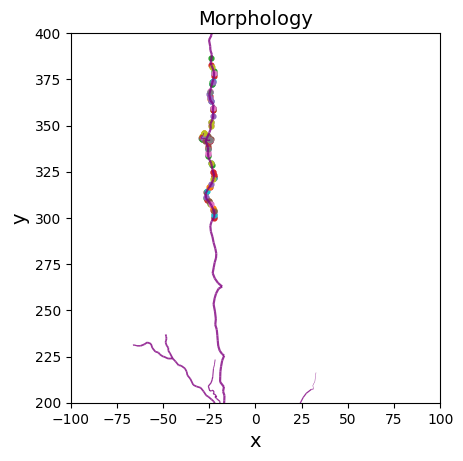

In [161]:
all_clusters = generate_neurite_locations_on(m, 1, 100, 20, 350.0, 10, 50, lst_section_types=[4])

xyz = pandas.concat([all_clusters.apply(location_xyz, axis=1), all_clusters["presyn_id"]], axis=1)
neurom.view.plot_morph(neurom.io.utils.Morphology(m))
_ = xyz.groupby("presyn_id").apply(lambda _x: plt.scatter(_x["x"], _x["y"], s=12))

plt.gca().set_xlim([-100, 100])
plt.gca().set_ylim([200, 400])

In [ ]:
import os, h5py

def initialize_sonata_edge_file(fn_out):
    assert not os.path.exists(fn_out)
    with h5py.File(fn_out, "w") as h5:
        grp_main = h5.create_group("edges").create_group("synaptome")
        yield grp_main
        yield grp_main.create_group("0")
        grp_indices = grp_main.create_group("indices")
        yield grp_indices.create_group("source_to_target")
        yield grp_indices.create_group("target_to_source")

def write_synapse_properties(grp, df):
    tl_dict = {
        "segment_id": "afferent_segment_id",
        "section_id": "afferent_section_id",
        "section_type": "afferent_section_type",
        "segment_offset": "afferent_segment_offset",
        "normalized_section_offset": "afferent_section_pos"
    }
    type_dict = {
        "afferent_segment_id": int,
        "afferent_section_id": int,
        "afferent_section_type": int,
        "afferent_segment_offset": float,
        "afferent_section_pos": float
    }
    df = df.rename(columns=tl_dict)
    for col in tl_dict.values():
        grp.create_dataset(col, data=df[col].values.astype(type_dict[col]))

def write_source_target_nodes(grp, df):
    grp.create_dataset("source_node_id", data=df["presyn_id"].values.astype(int))
    grp.create_dataset("target_node_id", data=numpy.zeros(len(df), dtype=int))

def write_source_indices(grp, df):
    n = df["presyn_id"].value_counts()
    n = n.reindex(range(n.index.max() + 1))
    cum_n = numpy.hstack([0, numpy.cumsum(n.values)])
    source_to_target_a = numpy.vstack([
        numpy.arange(len(cum_n) - 1),
        numpy.arange(1, len(cum_n))
    ]).transpose()
    source_to_target_b = numpy.vstack([cum_n[:-1], cum_n[1:]]).transpose()
    grp.create_dataset("node_id_to_ranges", data=source_to_target_a)
    grp.create_dataset("range_to_edge_id", data=source_to_target_b)

def write_target_indices(grp, df):
    target_to_source_a = numpy.array([[0, 1]])
    target_to_source_b = numpy.array([[0, len(df)]])
    grp.create_dataset("node_id_to_ranges", data=target_to_source_a)
    grp.create_dataset("range_to_edge_id", data=target_to_source_b)

def write_synaptome_sonata_edge_file(df, fn_out):
    df = df.sort_values("presyn_id")
    init = initialize_sonata_edge_file(fn_out)
    write_source_target_nodes(init.__next__(), df)
    write_synapse_properties(init.__next__(), df)
    write_source_indices(init.__next__(), df)
    write_target_indices(init.__next__(), df)


write_synaptome_sonata_edge_file(all_clusters, "foo.h5")



In [18]:
from os import path, listdir

def recursive_file_list(root, extension):
    lst = listdir(root)
    out = []
    for fn in lst:
        full_fn = path.join(root, fn)
        if path.isfile(full_fn):
            if path.splitext(fn)[1] == extension:
                out.append(full_fn)
        elif path.isdir(full_fn):
            out.extend(recursive_file_list(full_fn, extension))
    return out
     
recursive_file_list("/Users/mwr/Documents/repositories/ConnectomeUtilities/conntility", ".py")

import subprocess

for _fn in recursive_file_list("/Users/mwr/Documents/repositories/ConnectomeUtilities/conntility", ".py"):
    # subprocess.check_call([
    #     "sed",
    #     "-i",
    #     "-e",
    #     "s|numpy.NaN|numpy.nan|g",
    #     _fn
    # ])
    subprocess.check_call([
        "sed",
        "-i",
        "-e",
        "s|np.NaN|np.nan|g",
        _fn
    ])
